In [8]:
import pandas as pd
from clearml import Task
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import mannwhitneyu
import gc

def exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

def download_and_process_tasks_batch(tag, experiment_name, batch_size=20):
    print(f"DOWNLOADING TASKS FOR {experiment_name}: {tag}")
    tasks = Task.get_tasks(project_name="oho", tags=[tag], allow_archived=False)
    print(f"Found {len(tasks)} tasks (excluding archived)")
    
    all_dfs = []
    for batch_start in range(0, len(tasks), batch_size):
        batch_end = min(batch_start + batch_size, len(tasks))
        batch_tasks = tasks[batch_start:batch_end]
        print(f"Processing batch {batch_start + 1}-{batch_end}/{len(tasks)}")
        
        data_rows = []
        for task in batch_tasks:
            base_task_data = {"task_id": task.id, "task_name": task.name}
            
            # Get config
            params = task.get_parameters() or {}
            for key, value in params.items():
                if any(x in key for x in ["learning_rate", "optimizer/_type", "seed/global_seed"]):
                    base_task_data[key] = value
            
            # Get metrics
            reported_scalars = task.get_reported_scalars()
            has_time_series = False
            
            for metric_name in ["validation/loss", "test/loss", "final_test/loss", "train/learning_rate"]:
                if metric_name in reported_scalars:
                    variants = reported_scalars[metric_name]
                    for variant, data in variants.items():
                        if data["x"] and data["y"]:
                            for iteration, value in zip(data["x"], data["y"]):
                                if isinstance(value, (int, float)):
                                    row = base_task_data.copy()
                                    row["iteration"] = iteration
                                    row[f"metric/{metric_name}/{variant}"] = value
                                    data_rows.append(row)
                                    has_time_series = True
            
            if not has_time_series:
                data_rows.append(base_task_data)
        
        if data_rows:
            all_dfs.append(pd.DataFrame(data_rows))
        gc.collect()
    
    df = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()
    print(f"DataFrame created: {df.shape}")
    
    # Check for zero and -1 values in final test loss
    final_test_cols = [col for col in df.columns if "final_test" in col and "loss" in col]
    if final_test_cols and not df.empty:
        invalid_count = ((df[final_test_cols[0]] == 0) | (df[final_test_cols[0]] == -1)).sum()
        if invalid_count > 0:
            print(f"WARNING: {invalid_count} invalid values (0 or -1) detected in final test loss!")
    
    return df

def check_invalid_test_losses(df, experiment_name, best_config, is_dual=False, optimizer_type=None):
    """Check for invalid test losses in the best configuration and report details"""
    print(f"\nCHECKING INVALID TEST LOSSES for {experiment_name}")
    
    # Get test loss columns (both iteration-wise and final)
    test_loss_cols = [col for col in df.columns if "test/loss" in col]
    final_test_cols = [col for col in df.columns if "final_test" in col and "loss" in col]
    
    if not test_loss_cols and not final_test_cols:
        print("No test loss columns found")
        return {}
    
    # Filter data for best configuration
    if is_dual:
        lr0_key = "config/learners/0/optimizer/learning_rate"
        lr1_key = "config/learners/1/optimizer/learning_rate"
        best_data = df[
            (df[lr0_key] == best_config[lr0_key]) &
            (df[lr1_key] == best_config[lr1_key])
        ]
        config_str = f"LR0={best_config[lr0_key]}, LR1={best_config[lr1_key]}"
        
        # Also filter by optimizer type if provided
        if optimizer_type:
            best_data = best_data[best_data["config/learners/0/optimizer/_type"] == optimizer_type]
            config_str += f", Optimizer={optimizer_type}"
    else:
        lr_key = "config/learners/0/optimizer/learning_rate"
        best_data = df[df[lr_key] == best_config[lr_key]]
        config_str = f"LR={best_config[lr_key]}"
    
    print(f"Best configuration: {config_str}")
    print(f"Total data points for best config: {len(best_data)}")
    
    # Report optimizer types in the filtered data
    if "config/learners/0/optimizer/_type" in best_data.columns:
        opt_types = best_data["config/learners/0/optimizer/_type"].dropna().unique()
        print(f"Optimizer types in best config data: {list(opt_types)}")
    
    invalid_reports = {}
    
    # Check iteration-wise test losses
    for col in test_loss_cols:
        test_data = best_data[best_data[col].notna()]
        if len(test_data) == 0:
            continue
            
        # Check for invalid values (0, -1, inf, nan after filtering)
        invalid_mask = (
            (test_data[col] == 0) | 
            (test_data[col] == -1) | 
            np.isinf(test_data[col]) |
            (test_data[col] < 0)  # Negative losses are suspicious
        )
        
        invalid_data = test_data[invalid_mask]
        
        if len(invalid_data) > 0:
            print(f"\nInvalid values found in {col}:")
            print(f"  Total invalid: {len(invalid_data)}/{len(test_data)} data points")
            
            # Group by task and report
            invalid_by_task = invalid_data.groupby(['task_id', 'task_name']).agg({
                col: ['count', 'min', 'max'],
                'iteration': ['min', 'max'],
                'config/seed/global_seed': 'first'
            }).reset_index()
            
            invalid_by_task.columns = ['task_id', 'task_name', 'invalid_count', 'min_invalid_loss', 'max_invalid_loss', 
                                     'min_iter', 'max_iter', 'seed']
            
            print(f"  Affected tasks: {len(invalid_by_task)}")
            for _, row in invalid_by_task.iterrows():
                print(f"    Task {row['task_id']} (seed {row['seed']}): {row['invalid_count']} invalid values "
                      f"at iterations {row['min_iter']}-{row['max_iter']}, "
                      f"loss range [{row['min_invalid_loss']}, {row['max_invalid_loss']}]")
            
            invalid_reports[col] = {
                'total_invalid': len(invalid_data),
                'total_valid': len(test_data) - len(invalid_data),
                'affected_tasks': invalid_by_task.to_dict('records')
            }
    
    # Check final test losses
    for col in final_test_cols:
        final_data = best_data[best_data[col].notna()].drop_duplicates(['task_id'])
        if len(final_data) == 0:
            continue
            
        invalid_mask = (
            (final_data[col] == 0) | 
            (final_data[col] == -1) | 
            np.isinf(final_data[col]) |
            (final_data[col] < 0)
        )
        
        invalid_final = final_data[invalid_mask]
        
        if len(invalid_final) > 0:
            print(f"\nInvalid values found in {col}:")
            print(f"  Total invalid: {len(invalid_final)}/{len(final_data)} tasks")
            
            for _, row in invalid_final.iterrows():
                print(f"    Task {row['task_id']} (seed {row['config/seed/global_seed']}): "
                      f"final test loss = {row[col]}")
            
            invalid_reports[col] = {
                'total_invalid': len(invalid_final),
                'total_valid': len(final_data) - len(invalid_final),
                'affected_tasks': invalid_final[['task_id', 'task_name', 'config/seed/global_seed', col]].to_dict('records')
            }
    
    return invalid_reports

def get_best_config(df, is_dual=False, filter_invalid=True):
    """Get best configuration based on validation loss"""
    final_test_cols = [col for col in df.columns if "final_test" in col and "loss" in col]
    if not final_test_cols:
        return None, None
    
    final_test_col = final_test_cols[0]
    lr_cols = ["config/learners/0/optimizer/learning_rate"]
    if is_dual:
        lr_cols.append("config/learners/1/optimizer/learning_rate")
    
    validation_data = df.dropna(subset=["metric/validation/loss/validation_loss"] + lr_cols)
    if validation_data.empty:
        return None, None
    
    # Handle invalid final test losses
    if filter_invalid:
        # Filter out configs with zero final test losses
        if is_dual:
            lr_pairs = validation_data[lr_cols].drop_duplicates()
            valid_pairs = []
            for _, row in lr_pairs.iterrows():
                lr0, lr1 = row[lr_cols[0]], row[lr_cols[1]]
                final_test_data = df.dropna(subset=[final_test_col])
                pair_data = final_test_data[
                    (final_test_data[lr_cols[0]] == lr0) & 
                    (final_test_data[lr_cols[1]] == lr1)
                ]
                if len(pair_data) > 0 and ((pair_data[final_test_col] == 0) | (pair_data[final_test_col] == -1)).sum() == 0:
                    valid_pairs.append((lr0, lr1))
            
            if not valid_pairs:
                return None, None
            
            valid_mask = validation_data.apply(
                lambda x: (x[lr_cols[0]], x[lr_cols[1]]) in valid_pairs, axis=1
            )
            validation_data = validation_data[valid_mask]
            group_cols = lr_cols
        else:
            learning_rates = validation_data[lr_cols[0]].unique()
            valid_lrs = []
            for lr in learning_rates:
                final_test_data = df.dropna(subset=[final_test_col, lr_cols[0]])
                lr_data = final_test_data[final_test_data[lr_cols[0]] == lr]
                if len(lr_data) > 0 and ((lr_data[final_test_col] == 0) | (lr_data[final_test_col] == -1)).sum() == 0:
                    valid_lrs.append(lr)
            
            if not valid_lrs:
                return None, None
            
            validation_data = validation_data[validation_data[lr_cols[0]].isin(valid_lrs)]
            group_cols = lr_cols
    else:
        group_cols = lr_cols
    
    # Get last iteration validation loss for each task and config
    last_iter = validation_data.groupby(["task_id"] + group_cols).agg({
        "iteration": "max", "metric/validation/loss/validation_loss": "last"
    }).reset_index()
    
    last_iter_data = validation_data.merge(
        last_iter[["task_id"] + group_cols + ["iteration"]], 
        on=["task_id"] + group_cols + ["iteration"]
    )
    
    # Get best config by validation loss
    lr_summary = last_iter_data.groupby(group_cols).agg({
        "metric/validation/loss/validation_loss": "mean"
    }).reset_index().sort_values("metric/validation/loss/validation_loss")
    
    best_row = lr_summary.iloc[0]
    best_config = {col: best_row[col] for col in group_cols}
    
    # Get runner-ups
    runner_ups = []
    for i in range(1, min(3, len(lr_summary))):
        runner_up = lr_summary.iloc[i]
        config = {col: runner_up[col] for col in group_cols}
        
        # Get final test losses for this config
        final_test_data = df.dropna(subset=[final_test_col] + group_cols)
        config_mask = True
        for col in group_cols:
            config_mask = config_mask & (final_test_data[col] == config[col])
        config_final = final_test_data[config_mask].drop_duplicates(["task_id"])
        
        if len(config_final) > 0:
            runner_ups.append({
                'rank': i + 1,
                **{f'lr{j}' if is_dual else 'lr': v for j, (k, v) in enumerate(config.items())},
                'validation_loss': runner_up["metric/validation/loss/validation_loss"],
                'final_test_loss': np.mean(config_final[final_test_col]),
                'n_tasks': len(config_final)
            })
    
    return best_config, runner_ups

def analyze_experiment(df, experiment_name, filter_invalid=True):
    """Unified analysis for single/dual optimizer experiments"""
    print(f"ANALYZING {experiment_name}")
    
    final_test_cols = [col for col in df.columns if "final_test" in col and "loss" in col]
    if not final_test_cols:
        print("ERROR: No final test loss column found")
        return {}
    
    final_test_col = final_test_cols[0]
    is_dual = "config/learners/1/optimizer/learning_rate" in df.columns
    
    if is_dual:
        optimizer_types = df["config/learners/0/optimizer/_type"].dropna().unique()
        results = {}
        
        for opt_type in optimizer_types:
            print(f"\nAnalyzing {opt_type}")
            opt_df = df[df["config/learners/0/optimizer/_type"] == opt_type]
            best_config, runner_ups = get_best_config(opt_df, is_dual=True, filter_invalid=filter_invalid)   
                     
            if best_config is None:
                continue
            
            lr0, lr1 = best_config["config/learners/0/optimizer/learning_rate"], best_config["config/learners/1/optimizer/learning_rate"]
            print(f"Best LR pair: learner0={lr0}, learner1={lr1}")
            
            # Check for invalid test losses in best config
            invalid_reports = check_invalid_test_losses(opt_df, f"{experiment_name}-{opt_type}", best_config, is_dual=True, optimizer_type=opt_type)
            
            # Get final test losses and filter invalid if needed
            final_test_data = opt_df.dropna(subset=[final_test_col])
            best_final = final_test_data[
                (final_test_data["config/learners/0/optimizer/learning_rate"] == lr0) &
                (final_test_data["config/learners/1/optimizer/learning_rate"] == lr1)
            ].drop_duplicates(["task_id"])
            
            if not filter_invalid:
                # Filter out invalid tasks and report
                total_tasks = len(best_final)
                invalid_mask = (best_final[final_test_col] == 0) | (best_final[final_test_col] == -1)
                invalid_count = invalid_mask.sum()
                
                if invalid_count > 0:
                    print(f"WARNING: Filtering out {invalid_count}/{total_tasks} tasks with invalid final test loss (0 or -1)")
                    best_final = best_final[~invalid_mask]
                
                if len(best_final) == 0:
                    print(f"ERROR: No valid tasks remaining for {opt_type} after filtering")
                    continue
            
            final_losses = best_final[final_test_col].values
            print(f"Final test loss: mean={np.mean(final_losses):.6f}, std={np.std(final_losses):.6f}, n={len(final_losses)}")
            
            # Get effective learning rates
            test_curves = opt_df[
                (opt_df["config/learners/0/optimizer/learning_rate"] == lr0) &
                (opt_df["config/learners/1/optimizer/learning_rate"] == lr1) &
                opt_df["metric/test/loss/test_loss"].notna()
            ]
            
            eff_lrs = []
            if not test_curves.empty:
                for seed in test_curves["config/seed/global_seed"].unique():
                    seed_data = test_curves[test_curves["config/seed/global_seed"] == seed]
                    if len(seed_data) > 5:
                        try:
                            popt, _ = curve_fit(exp_decay, seed_data["iteration"], 
                                              seed_data["metric/test/loss/test_loss"],
                                              bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                            eff_lrs.append(popt[1])
                        except:
                            continue
            
            if eff_lrs:
                print(f"Effective LR: mean={np.mean(eff_lrs):.6f}, std={np.std(eff_lrs):.6f}, n={len(eff_lrs)}")
            
            # Get learning rate curves
            learning_rate_curves = {}
            
            # Filter data for best config first
            lr_curves_data = opt_df[
                (opt_df["config/learners/0/optimizer/learning_rate"] == lr0) &
                (opt_df["config/learners/1/optimizer/learning_rate"] == lr1)
            ]
            
            # Look for learning rate columns
            lr_cols = [col for col in lr_curves_data.columns if "train/learning_rate" in col]
            if not lr_cols:
                # Try alternative patterns
                lr_cols = [col for col in lr_curves_data.columns if "learning_rate" in col and "metric" in col]
            
            if lr_cols and not lr_curves_data.empty:
                lr_col = lr_cols[0]
                lr_data = lr_curves_data[lr_curves_data[lr_col].notna()]
                
                if not lr_data.empty:
                    seeds = lr_data["config/seed/global_seed"].unique()
                    
                    for seed in seeds:
                        seed_data = lr_data[lr_data["config/seed/global_seed"] == seed]
                        if len(seed_data) > 0:
                            # Sort by iteration to ensure proper ordering
                            seed_data = seed_data.sort_values('iteration')
                            learning_rate_curves[seed] = {
                                'iterations': seed_data["iteration"].values,
                                'learning_rates': seed_data[lr_col].values
                            }
            
            results[opt_type] = {
                "best_lr0": lr0, "best_lr1": lr1, "final_losses": final_losses,
                "effective_learning_rates": eff_lrs, "learning_rate_curves": learning_rate_curves,
                "runner_ups": runner_ups, "invalid_reports": invalid_reports
            }
        
        return results
    else:
        # Single optimizer analysis
        best_config, runner_ups = get_best_config(df, is_dual=False, filter_invalid=filter_invalid)
        if best_config is None:
            return {}
        
        best_lr = best_config["config/learners/0/optimizer/learning_rate"]
        print(f"Best learning rate: {best_lr}")
        
        # Check for invalid test losses in best config
        invalid_reports = check_invalid_test_losses(df, experiment_name, best_config, is_dual=False)
        
        # Get final test losses and filter invalid if needed
        final_test_data = df.dropna(subset=[final_test_col])
        best_final = final_test_data[
            final_test_data["config/learners/0/optimizer/learning_rate"] == best_lr
        ].drop_duplicates(["task_id"])
        
        if not filter_invalid:
            # Filter out invalid tasks and report
            total_tasks = len(best_final)
            invalid_mask = (best_final[final_test_col] == 0) | (best_final[final_test_col] == -1)
            invalid_count = invalid_mask.sum()
            
            if invalid_count > 0:
                print(f"WARNING: Filtering out {invalid_count}/{total_tasks} tasks with invalid final test loss (0 or -1)")
                best_final = best_final[~invalid_mask]
            
            if len(best_final) == 0:
                print(f"ERROR: No valid tasks remaining after filtering")
                return {}
        
        final_losses = best_final[final_test_col].values
        print(f"Final test loss: mean={np.mean(final_losses):.6f}, std={np.std(final_losses):.6f}, n={len(final_losses)}")
        
        # Get effective learning rates
        test_curves = df[
            (df["config/learners/0/optimizer/learning_rate"] == best_lr) &
            df["metric/test/loss/test_loss"].notna()
        ]
        
        eff_lrs = []
        if not test_curves.empty:
            for seed in test_curves["config/seed/global_seed"].unique():
                seed_data = test_curves[test_curves["config/seed/global_seed"] == seed]
                if len(seed_data) > 5:
                    try:
                        popt, _ = curve_fit(exp_decay, seed_data["iteration"], 
                                          seed_data["metric/test/loss/test_loss"],
                                          bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                        eff_lrs.append(popt[1])
                    except:
                        continue
        
        if eff_lrs:
            print(f"Effective LR: mean={np.mean(eff_lrs):.6f}, std={np.std(eff_lrs):.6f}, n={len(eff_lrs)}")
        
        return {
            "single_optimizer": {
                "best_lr0": best_lr, "final_losses": final_losses,
                "effective_learning_rates": eff_lrs, "learning_rate_curves": {},
                "runner_ups": runner_ups, "invalid_reports": invalid_reports
            }
        }

def create_mannwhitney_table(all_conditions):
    """Create formatted table for Mann-Whitney U test results"""
    test_results = []
    
    for i in range(len(all_conditions)):
        for j in range(i + 1, len(all_conditions)):
            name1, data1 = all_conditions[i]
            name2, data2 = all_conditions[j]
            
            result_row = {'Comparison': f"{name1} vs {name2}"}
            
            # Final test loss (lower is better)
            if len(data1["final_losses"]) > 0 and len(data2["final_losses"]) > 0:
                _, p_val = mannwhitneyu(data1["final_losses"], data2["final_losses"])
                result_row['Final Test Loss p-value'] = f"{p_val:.6f}"
                if p_val < 0.05:
                    winner = name1 if np.mean(data1["final_losses"]) < np.mean(data2["final_losses"]) else name2
                    result_row['Final Test Loss Winner'] = winner
                else:
                    result_row['Final Test Loss Winner'] = "No difference"
            else:
                result_row.update({'Final Test Loss p-value': "N/A", 'Final Test Loss Winner': "N/A"})
            
            # Effective learning rate (higher is better)
            if len(data1["effective_learning_rates"]) > 0 and len(data2["effective_learning_rates"]) > 0:
                _, p_val = mannwhitneyu(data1["effective_learning_rates"], data2["effective_learning_rates"])
                result_row['Effective LR p-value'] = f"{p_val:.6f}"
                if p_val < 0.05:
                    winner = name1 if np.mean(data1["effective_learning_rates"]) > np.mean(data2["effective_learning_rates"]) else name2
                    result_row['Effective LR Winner'] = winner
                else:
                    result_row['Effective LR Winner'] = "No difference"
            else:
                result_row.update({'Effective LR p-value': "N/A", 'Effective LR Winner': "N/A"})
            
            test_results.append(result_row)
    
    return pd.DataFrame(test_results)

def plot_mannwhitney_table(df_results):
    """Create figure showing Mann-Whitney U test results as table"""
    if df_results.empty:
        return
    
    fig, ax = plt.subplots(figsize=(16, max(4, len(df_results) * 0.8)))
    ax.axis('tight')
    ax.axis('off')
    
    headers = ['Comparison', 'Final Test Loss\np-value', 'Final Test Loss\nWinner', 
               'Effective LR\np-value', 'Effective LR\nWinner']
    table_data = df_results.values.tolist()
    
    table = ax.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 2)
    
    # Color code results
    for i in range(len(table_data)):
        for j in range(len(headers)):
            cell = table[(i+1, j)]
            if j in [1, 3]:  # p-value columns
                try:
                    p_val = float(table_data[i][j])
                    cell.set_facecolor('#ffcccc' if p_val < 0.05 else '#ccffcc')
                except:
                    cell.set_facecolor('#f0f0f0')
            elif j in [2, 4] and table_data[i][j] != "No difference":
                cell.set_facecolor('#ffffcc')
    
    # Style headers
    for j in range(len(headers)):
        cell = table[(0, j)]
        cell.set_facecolor('#4472C4')
        cell.set_text_props(weight='bold', color='white')
    
    plt.title('Mann-Whitney U Test Results\n(Red: p < 0.05, Green: p ≥ 0.05, Yellow: Winner)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def plot_scatterplot_lr_vs_loss_diff(dataframes, results, experiment_names):
    """Create scatterplot: final learning rate vs final test loss difference (OHO - Fixed LR)"""
    if len(dataframes) != 2 or len(experiment_names) != 2:
        print("Scatterplot requires exactly 2 experiments")
        return
    
    # Identify which experiment is Fixed LR vs OHO based on number of optimizer types
    exp1, exp2 = experiment_names
    
    # Check if one experiment has fewer optimizer types (likely Fixed LR)
    exp1_keys = list(results[exp1].keys())
    exp2_keys = list(results[exp2].keys())
    
    if len(exp1_keys) == 1 and len(exp2_keys) > 1:
        exp_fixed, exp_oho = exp1, exp2
        df_fixed, df_oho = dataframes[0], dataframes[1]
    elif len(exp2_keys) == 1 and len(exp1_keys) > 1:
        exp_fixed, exp_oho = exp2, exp1
        df_fixed, df_oho = dataframes[1], dataframes[0]
    else:
        # If both have same number of keys, assume first is Fixed LR, second is OHO
        print(f"Both experiments have similar structure. Assuming {exp1} is Fixed LR and {exp2} is OHO")
        exp_fixed, exp_oho = exp1, exp2
        df_fixed, df_oho = dataframes[0], dataframes[1]
    
    # Get Fixed LR results (take the first/only optimizer type)
    fixed_opt_type = list(results[exp_fixed].keys())[0]
    fixed_results = results[exp_fixed][fixed_opt_type]
    fixed_lr = fixed_results["best_lr0"]
    
    print(f"Using {exp_fixed} ({fixed_opt_type}) as Fixed LR baseline with LR={float(fixed_lr):.6f}")
    print(f"Comparing against {exp_oho} with optimizer types: {list(results[exp_oho].keys())}")
    
    # Get final test loss column
    final_test_cols = [col for col in df_fixed.columns if "final_test" in col and "loss" in col]
    if not final_test_cols:
        print("No final test loss column found")
        return
    final_test_col = final_test_cols[0]
    
    # Get fixed LR final test losses by seed
    fixed_final = df_fixed.dropna(subset=[final_test_col, "config/seed/global_seed"])
    fixed_final = fixed_final[fixed_final["config/learners/0/optimizer/learning_rate"] == fixed_lr]
    fixed_by_seed = fixed_final.groupby("config/seed/global_seed")[final_test_col].first().to_dict()
    
    # Loop through each optimizer type in OHO
    for opt_type, oho_results in results[exp_oho].items():
        print(f"\nCreating scatterplot for {opt_type}")
        
        oho_lr0, oho_lr1 = oho_results["best_lr0"], oho_results["best_lr1"]
        
        # Get OHO final test losses and final learning rates by seed
        oho_final = df_oho.dropna(subset=[final_test_col, "config/seed/global_seed"])
        oho_final = oho_final[
            (oho_final["config/learners/0/optimizer/learning_rate"] == oho_lr0) &
            (oho_final["config/learners/1/optimizer/learning_rate"] == oho_lr1)
        ]
        oho_by_seed = oho_final.groupby("config/seed/global_seed")[final_test_col].first().to_dict()
        
        # Get final learning rates for OHO by seed
        lr_cols = [col for col in df_oho.columns if "train/learning_rate" in col]
        if not lr_cols:
            print(f"No learning rate evolution data found for OHO {opt_type}")
            continue
        
        lr_col = lr_cols[0]
        oho_lr_data = df_oho[
            (df_oho["config/learners/0/optimizer/learning_rate"] == oho_lr0) &
            (df_oho["config/learners/1/optimizer/learning_rate"] == oho_lr1) &
            df_oho[lr_col].notna()
        ]
        
        # Get final learning rate for each seed (last iteration)
        final_lrs_by_seed = {}
        for seed in oho_lr_data["config/seed/global_seed"].unique():
            seed_data = oho_lr_data[oho_lr_data["config/seed/global_seed"] == seed]
            if len(seed_data) > 0:
                max_iter = seed_data["iteration"].max()
                final_lr = seed_data[seed_data["iteration"] == max_iter][lr_col].iloc[0]
                final_lrs_by_seed[seed] = final_lr
        
        # Create scatterplot data
        scatter_data = []
        for seed in final_lrs_by_seed.keys():
            if seed in fixed_by_seed and seed in oho_by_seed:
                fixed_loss = fixed_by_seed[seed]
                oho_loss = oho_by_seed[seed]
                final_lr = final_lrs_by_seed[seed]
                loss_diff = oho_loss - fixed_loss  # Positive means OHO is worse
                
                scatter_data.append({
                    'seed': seed,
                    'final_lr': final_lr,
                    'loss_diff': loss_diff,
                    'fixed_loss': fixed_loss,
                    'oho_loss': oho_loss
                })
        
        if not scatter_data:
            print(f"No matching seeds found between experiments for {opt_type}")
            continue
        
        scatter_df = pd.DataFrame(scatter_data)
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Color points based on whether OHO is better (negative diff) or worse (positive diff)
        colors = ['red' if diff > 0 else 'blue' for diff in scatter_df['loss_diff']]
        
        scatter = ax.scatter(scatter_df['final_lr'], scatter_df['loss_diff'], 
                            c=colors, alpha=0.7, s=50)
        
        # Add seed labels to each point
        for i, row in scatter_df.iterrows():
            ax.annotate(str(int(row['seed'])), 
                       (row['final_lr'], row['loss_diff']),
                       xytext=(3, 3), textcoords='offset points',
                       fontsize=8, alpha=0.8)
        
        # Add horizontal line at y=0 (no difference)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
        
        # Labels and title
        ax.set_xlabel('Final Learning Rate (OHO)')
        ax.set_ylabel('Final Test Loss Difference (OHO - Fixed LR)')
        ax.set_title(f'Final Learning Rate vs Final Test Loss Difference ({opt_type})\n'
                    f'Fixed LR: {float(fixed_lr):.6f}, OHO Best: LR0={float(oho_lr0):.6f}, LR1={float(oho_lr1):.6f}\n'
                    f'Blue: OHO Better, Red: Fixed LR Better')
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Set log scale for x-axis if learning rates span multiple orders of magnitude
        lr_range = scatter_df['final_lr'].max() / scatter_df['final_lr'].min()
        if lr_range > 10:
            ax.set_xscale('log')
        
        # Add summary statistics
        better_count = (scatter_df['loss_diff'] < 0).sum()
        worse_count = (scatter_df['loss_diff'] > 0).sum()
        mean_diff = scatter_df['loss_diff'].mean()
        
        stats_text = f'OHO Better: {better_count}/{len(scatter_df)} seeds\n'
        stats_text += f'Mean Difference: {mean_diff:.6f}\n'
        stats_text += f'Final LR Range: {scatter_df["final_lr"].min():.6f} - {scatter_df["final_lr"].max():.6f}'
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed statistics
        print(f"\nSCATTERPLOT ANALYSIS for {opt_type}:")
        print(f"Total seeds: {len(scatter_df)}")
        print(f"OHO better (negative diff): {better_count} seeds")
        print(f"Fixed LR better (positive diff): {worse_count} seeds")
        print(f"Mean loss difference (OHO - Fixed): {mean_diff:.6f}")
        print(f"Std loss difference: {scatter_df['loss_diff'].std():.6f}")
        print(f"Final LR range: {scatter_df['final_lr'].min():.6f} to {scatter_df['final_lr'].max():.6f}")
        
        # Correlation analysis
        correlation = scatter_df['final_lr'].corr(scatter_df['loss_diff'])
        print(f"Correlation between final LR and loss difference: {correlation:.4f}")

def compute_valid_test_loss_stats(df, best_config, is_dual=False, optimizer_type=None):
    """Compute test loss statistics excluding invalid values for each iteration"""
    
    # Filter data for best configuration
    if is_dual:
        lr0_key = "config/learners/0/optimizer/learning_rate"
        lr1_key = "config/learners/1/optimizer/learning_rate"
        best_data = df[
            (df[lr0_key] == best_config[lr0_key]) &
            (df[lr1_key] == best_config[lr1_key])
        ]
        
        # Also filter by optimizer type if provided
        if optimizer_type:
            best_data = best_data[best_data["config/learners/0/optimizer/_type"] == optimizer_type]
    else:
        lr_key = "config/learners/0/optimizer/learning_rate"
        best_data = df[df[lr_key] == best_config[lr_key]]
    
    # Get test loss column
    test_loss_cols = [col for col in best_data.columns if "test/loss" in col and "final_test" not in col]
    if not test_loss_cols:
        return None
    
    test_loss_col = test_loss_cols[0]
    test_data = best_data[best_data[test_loss_col].notna()]
    
    if len(test_data) == 0:
        return None
    
    # Report optimizer types in the data being processed
    if "config/learners/0/optimizer/_type" in test_data.columns:
        opt_types = test_data["config/learners/0/optimizer/_type"].dropna().unique()
        print(f"    Processing optimizer types: {list(opt_types)}")
    
    # Filter out invalid values for each iteration
    valid_test_data = test_data[
        (test_data[test_loss_col] > 0) &  # Positive losses only
        (test_data[test_loss_col] != -1) &  # Remove -1 values
        np.isfinite(test_data[test_loss_col])  # Remove inf/nan
    ]
    
    if len(valid_test_data) == 0:
        return None
    
    # Compute statistics per iteration
    stats = valid_test_data.groupby('iteration')[test_loss_col].agg([
        'mean', 'std', 
        lambda x: np.percentile(x, 25), 
        lambda x: np.percentile(x, 75), 
        'count'
    ]).reset_index()
    stats.columns = ['iteration', 'mean', 'std', 'q1', 'q3', 'count']
    
    # Only keep iterations with at least 3 valid measurements
    stats = stats[stats['count'] >= 3]
    
    # Report filtering statistics
    total_points = len(test_data)
    valid_points = len(valid_test_data)
    invalid_points = total_points - valid_points
    
    if invalid_points > 0:
        print(f"    Filtered {invalid_points}/{total_points} invalid test loss values")
        
        # Report which tasks had invalid values with their optimizer types
        invalid_data = test_data[
            (test_data[test_loss_col] <= 0) |
            (test_data[test_loss_col] == -1) |
            ~np.isfinite(test_data[test_loss_col])
        ]
        
        if len(invalid_data) > 0:
            if "config/learners/0/optimizer/_type" in invalid_data.columns:
                invalid_tasks = invalid_data.groupby(['task_id', 'config/seed/global_seed', 'config/learners/0/optimizer/_type']).agg({
                    test_loss_col: 'count',
                    'iteration': ['min', 'max']
                }).reset_index()
                invalid_tasks.columns = ['task_id', 'seed', 'optimizer_type', 'invalid_count', 'min_iter', 'max_iter']
                
                print(f"    Tasks with invalid test losses:")
                for _, row in invalid_tasks.iterrows():
                    print(f"      Task {row['task_id']} (seed {row['seed']}, {row['optimizer_type']}): {row['invalid_count']} invalid values "
                          f"at iterations {row['min_iter']}-{row['max_iter']}")
            else:
                invalid_tasks = invalid_data.groupby(['task_id', 'config/seed/global_seed']).agg({
                    test_loss_col: 'count',
                    'iteration': ['min', 'max']
                }).reset_index()
                invalid_tasks.columns = ['task_id', 'seed', 'invalid_count', 'min_iter', 'max_iter']
                
                print(f"    Tasks with invalid test losses:")
                for _, row in invalid_tasks.iterrows():
                    print(f"      Task {row['task_id']} (seed {row['seed']}): {row['invalid_count']} invalid values "
                          f"at iterations {row['min_iter']}-{row['max_iter']}")
    
    return stats

def run_analysis(experiment_configs, filter_invalid=True):
    """Run analysis on multiple experiments"""
    dataframes = []
    results = {}
    
    for df, exp_name in experiment_configs:
        dataframes.append(df)
        results[exp_name] = analyze_experiment(df, exp_name, filter_invalid)
    
    return results, dataframes

def plot_and_test(all_results, experiment_dataframes):
    """Create plots and statistical tests with enhanced invalid value checking"""
    # Flatten conditions
    all_conditions = []
    condition_info = {}
    
    for exp_name, result_dict in all_results.items():
        for opt_type, data in result_dict.items():
            if opt_type == "single_optimizer":
                display_name = f"{exp_name}-Fixed LR"
                best_config = f"LR={float(data['best_lr0']):.6f}"
            else:
                display_name = f"{exp_name}-{opt_type}"
                best_config = f"LR0={float(data['best_lr0']):.6f}, LR1={float(data['best_lr1']):.6f}"
            
            all_conditions.append((display_name, data))
            condition_info[display_name] = best_config
    
    if not all_conditions:
        return
    
    # Calculate shared y-axis limits
    all_final_losses = [loss for _, data in all_conditions for loss in data["final_losses"]]
    all_eff_lrs = [lr for _, data in all_conditions for lr in data["effective_learning_rates"]]
    
    final_loss_ylim = (min(all_final_losses) * 0.95, max(all_final_losses) * 1.05) if all_final_losses else None
    eff_lr_ylim = (min(all_eff_lrs) * 0.95, max(all_eff_lrs) * 1.05) if all_eff_lrs else None
    
    # Create plots
    n_conditions = len(all_conditions)
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    # Violin and box plots
    for plot_type in ['violin', 'box']:
        fig, axes = plt.subplots(2, n_conditions, figsize=(4 * n_conditions, 8))
        if n_conditions == 1:
            axes = axes.reshape(2, 1)
        
        for i, (name, data) in enumerate(all_conditions):
            # Final test loss
            final_losses = data["final_losses"]
            if plot_type == 'violin':
                axes[0, i].violinplot([final_losses], positions=[0], showmeans=True, showmedians=True)
            else:
                axes[0, i].boxplot([final_losses], positions=[0], patch_artist=True,
                                 boxprops=dict(facecolor='lightblue', alpha=0.7))
            
            mean_val, std_val = np.mean(final_losses), np.std(final_losses)
            axes[0, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                          transform=axes[0, i].transAxes, va='top', ha='right',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            title = f"{name}: Final Test Loss\nBest: {condition_info[name]}"
            axes[0, i].set_title(title, fontsize=10)
            axes[0, i].set_ylabel("Final Test Loss")
            axes[0, i].set_xticks([0])
            axes[0, i].set_xticklabels([name.split("-")[-1]])
            if final_loss_ylim:
                axes[0, i].set_ylim(final_loss_ylim)
            
            # Effective learning rate
            if data["effective_learning_rates"]:
                eff_lrs = data["effective_learning_rates"]
                if plot_type == 'violin':
                    axes[1, i].violinplot([eff_lrs], positions=[0], showmeans=True, showmedians=True)
                else:
                    axes[1, i].boxplot([eff_lrs], positions=[0], patch_artist=True,
                                     boxprops=dict(facecolor='lightgreen', alpha=0.7))
                
                mean_val, std_val = np.mean(eff_lrs), np.std(eff_lrs)
                axes[1, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                               transform=axes[1, i].transAxes, va='top', ha='right',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                title = f"{name}: Effective LR\nBest: {condition_info[name]}"
                axes[1, i].set_title(title, fontsize=10)
                if eff_lr_ylim:
                    axes[1, i].set_ylim(eff_lr_ylim)
            else:
                axes[1, i].text(0.5, 0.5, "No Data", ha="center", va="center", 
                               transform=axes[1, i].transAxes)
                title = f"{name}: Effective LR (No Data)\nBest: {condition_info[name]}"
                axes[1, i].set_title(title, fontsize=10)
            
            axes[1, i].set_ylabel("Effective Learning Rate")
            axes[1, i].set_xticks([0])
            axes[1, i].set_xticklabels([name.split("-")[-1]])
        
        plt.tight_layout()
        plt.show()
    
    # Combined test loss curves with invalid value filtering
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    color_idx = 0
    for idx, (exp_name, result_dict) in enumerate(all_results.items()):
        df = experiment_dataframes[idx]
        
        for opt_type, data in result_dict.items():
            color = colors[color_idx % len(colors)]
            color_idx += 1
            
            if opt_type == "single_optimizer":
                best_config = {"config/learners/0/optimizer/learning_rate": data["best_lr0"]}
                is_dual = False
                label = f"{exp_name}-Fixed LR (LR={float(data['best_lr0']):.6f})"
            else:
                best_config = {
                    "config/learners/0/optimizer/learning_rate": data["best_lr0"],
                    "config/learners/1/optimizer/learning_rate": data["best_lr1"]
                }
                is_dual = True
                label = f"{exp_name}-{opt_type} (LR0={float(data['best_lr0']):.6f}, LR1={float(data['best_lr1']):.6f})"
            
            print(f"\nComputing valid test loss curves for {label}:")
            stats = compute_valid_test_loss_stats(df, best_config, is_dual, opt_type if opt_type != "single_optimizer" else None)
            
            if stats is not None and len(stats) > 0:
                iterations, means = stats['iteration'].values, stats['mean'].values
                upper_bound = np.maximum(means + stats['std'], stats['q3'])
                lower_bound = np.maximum(np.minimum(means - stats['std'], stats['q1']), 0)
                
                ax.plot(iterations, means, color=color, linewidth=2, label=label)
                ax.fill_between(iterations, lower_bound, upper_bound, color=color, alpha=0.2)
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Test Loss')
    ax.set_title('Test Loss Curves for Best Configurations (Invalid Values Filtered)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Individual test loss curves with shared y-axis and invalid filtering
    all_curve_data = []
    all_y_values = []
    
    for idx, (exp_name, result_dict) in enumerate(all_results.items()):
        df = experiment_dataframes[idx]
        
        for opt_type, data in result_dict.items():
            if opt_type == "single_optimizer":
                best_config = {"config/learners/0/optimizer/learning_rate": data["best_lr0"]}
                is_dual = False
                label = f"{exp_name}-Fixed LR (LR={float(data['best_lr0']):.6f})"
            else:
                best_config = {
                    "config/learners/0/optimizer/learning_rate": data["best_lr0"],
                    "config/learners/1/optimizer/learning_rate": data["best_lr1"]
                }
                is_dual = True
                label = f"{exp_name}-{opt_type} (LR0={float(data['best_lr0']):.6f}, LR1={float(data['best_lr1']):.6f})"
            
            print(f"\nComputing individual test loss curves for {label}:")
            stats = compute_valid_test_loss_stats(df, best_config, is_dual, opt_type if opt_type != "single_optimizer" else None)
            
            if stats is not None and len(stats) > 0:
                iterations, means = stats['iteration'].values, stats['mean'].values
                upper_bound = np.maximum(means + stats['std'], stats['q3'])
                lower_bound = np.maximum(np.minimum(means - stats['std'], stats['q1']), 0)
                
                all_curve_data.append((label, iterations, means, lower_bound, upper_bound))
                all_y_values.extend(lower_bound)
                all_y_values.extend(upper_bound)
    
    if all_curve_data:
        y_min, y_max = min(all_y_values) * 0.95, max(all_y_values) * 1.05
        n_plots = len(all_curve_data)
        fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 6))
        if n_plots == 1:
            axes = [axes]
        
        for i, (label, iterations, means, lower_bound, upper_bound) in enumerate(all_curve_data):
            color = colors[i % len(colors)]
            axes[i].plot(iterations, means, color=color, linewidth=2)
            axes[i].fill_between(iterations, lower_bound, upper_bound, color=color, alpha=0.3)
            axes[i].set_xlabel('Iteration')
            axes[i].set_ylabel('Test Loss')
            axes[i].set_title(label, fontsize=10)
            axes[i].set_ylim(y_min, y_max)
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Learning rate curves for dual optimizer experiments
    dual_experiments = []
    for exp_name, results in all_results.items():
        for opt_type, data in results.items():
            if opt_type != "single_optimizer" and data.get("learning_rate_curves"):
                dual_experiments.append((f"{exp_name}-{opt_type}", data))
    
    if dual_experiments:
        n_dual = len(dual_experiments)
        fig, axes = plt.subplots(1, n_dual, figsize=(8 * n_dual, 6))
        if n_dual == 1:
            axes = [axes]
        
        for i, (full_name, data) in enumerate(dual_experiments):
            learning_rate_curves = data["learning_rate_curves"]
            
            for seed, curve_data in learning_rate_curves.items():
                iterations = curve_data['iterations']
                learning_rates = curve_data['learning_rates']
                axes[i].plot(iterations, learning_rates, alpha=0.7, linewidth=1.5, label=f'Seed {seed}')
            
            axes[i].set_xlabel('Iteration')
            axes[i].set_ylabel('Learning Rate')
            best_config = f"LR0={float(data['best_lr0']):.6f}, LR1={float(data['best_lr1']):.6f}"
            axes[i].set_title(f'{full_name}: Learning Rate Evolution\nBest: {best_config}', fontsize=10)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            axes[i].set_yscale('log')  # Log scale often better for learning rates
        
        plt.tight_layout()
        plt.show()
    
    # Mann-Whitney U tests
    print(f"\nMANN-WHITNEY U TESTS:")
    mannwhitney_df = create_mannwhitney_table(all_conditions)
    
    if not mannwhitney_df.empty:
        plot_mannwhitney_table(mannwhitney_df)
        print("\nMann-Whitney U Test Results table displayed above")
        print("Note: p < 0.05 indicates significant difference")
        print("Final Test Loss: Lower is better")
        print("Effective LR: Higher is better (faster convergence)")
        
        # Detailed output
        for i in range(len(all_conditions)):
            for j in range(i + 1, len(all_conditions)):
                name1, data1 = all_conditions[i]
                name2, data2 = all_conditions[j]
                print(f"\n{name1} vs {name2}:")
                
                # Final test loss
                if len(data1["final_losses"]) > 0 and len(data2["final_losses"]) > 0:
                    _, p_value = mannwhitneyu(data1["final_losses"], data2["final_losses"])
                    print(f"  Final Test Loss: p={p_value:.6f}", end="")
                    if p_value < 0.05:
                        better = name1 if np.mean(data1["final_losses"]) < np.mean(data2["final_losses"]) else name2
                        print(f" - SIGNIFICANT: {better} has lower final test loss (BETTER)")
                    else:
                        print(f" - No significant difference")
                
                # Effective learning rate
                if len(data1["effective_learning_rates"]) > 0 and len(data2["effective_learning_rates"]) > 0:
                    _, p_value = mannwhitneyu(data1["effective_learning_rates"], data2["effective_learning_rates"])
                    print(f"  Effective LR: p={p_value:.6f}", end="")
                    if p_value < 0.05:
                        better = name1 if np.mean(data1["effective_learning_rates"]) > np.mean(data2["effective_learning_rates"]) else name2
                        print(f" - SIGNIFICANT: {better} has higher effective LR (BETTER)")
                    else:
                        print(f" - No significant difference")
    else:
        print("No valid comparisons for Mann-Whitney U tests")
    
    # Add scatterplot if we have exactly 2 experiments
    experiment_names = list(all_results.keys())
    if len(experiment_names) == 2:
        print(f"\nCREATING SCATTERPLOT:")
        plot_scatterplot_lr_vs_loss_diff(experiment_dataframes, all_results, experiment_names)

# Usage example:
# df_exp1 = download_and_process_tasks_batch("opt: a69a78c720634cebaf144cb8a23412c5", "Fixed LR")
# df_exp2 = download_and_process_tasks_batch("opt: ddda7173129846309c660479b5ff4460", "OHO")
# 
# experiment_configs = [
#     (df_exp1, "Fixed LR"),
#     (df_exp2, "OHO"),
# ]
# 
# results, dataframes = run_analysis(experiment_configs)
# plot_and_test(results, dataframes)

In [2]:
# Download data
df_exp1 = download_and_process_tasks_batch("opt: 8c83f4c7d6964236bb5d3b8349e4c72b", "EXPERIMENT 1")
df_exp2 = download_and_process_tasks_batch("opt: d2148c1ffc4a44b09d91069cc9dabbdc", "EXPERIMENT 2")

DOWNLOADING TASKS FOR EXPERIMENT 1: opt: 8c83f4c7d6964236bb5d3b8349e4c72b
Found 180 tasks (excluding archived)
Processing batch 1-20/180
Processing batch 21-40/180
Processing batch 41-60/180
Processing batch 61-80/180
Processing batch 81-100/180
Processing batch 101-120/180
Processing batch 121-140/180
Processing batch 141-160/180
Processing batch 161-180/180
DataFrame created: (1080720, 12)
DOWNLOADING TASKS FOR EXPERIMENT 2: opt: d2148c1ffc4a44b09d91069cc9dabbdc
Found 80 tasks (excluding archived)
Processing batch 1-20/80
Processing batch 21-40/80
Processing batch 41-60/80
Processing batch 61-80/80
DataFrame created: (480320, 12)


In [7]:
# df_exp3 = download_and_process_tasks_batch("opt: d2148c1ffc4a44b09d91069cc9dabbdc", "EXPERIMENT 3")

DOWNLOADING TASKS FOR EXPERIMENT 3: opt: d2148c1ffc4a44b09d91069cc9dabbdc
Found 80 tasks (excluding archived)
Processing batch 1-20/80
Processing batch 21-40/80
Processing batch 41-60/80
Processing batch 61-80/80
DataFrame created: (480320, 12)


ANALYZING Fixed LR

Analyzing SGDConfig
Best LR pair: learner0=0.202653362, learner1=0.01

CHECKING INVALID TEST LOSSES for Fixed LR-SGDConfig
Best configuration: LR0=0.202653362, LR1=0.01, Optimizer=SGDConfig
Total data points for best config: 120080
Optimizer types in best config data: ['SGDConfig']
Final test loss: mean=0.411269, std=0.017023, n=20
Effective LR: mean=0.002306, std=0.000103, n=20
ANALYZING OHO

Analyzing SGDConfig
Best LR pair: learner0=0.001, learner1=0.01

CHECKING INVALID TEST LOSSES for OHO-SGDConfig
Best configuration: LR0=0.001, LR1=0.01, Optimizer=SGDConfig
Total data points for best config: 120080
Optimizer types in best config data: ['SGDConfig']
Final test loss: mean=0.367190, std=0.041887, n=20
Effective LR: mean=0.002420, std=0.000087, n=20

Analyzing SGDNormalizedConfig


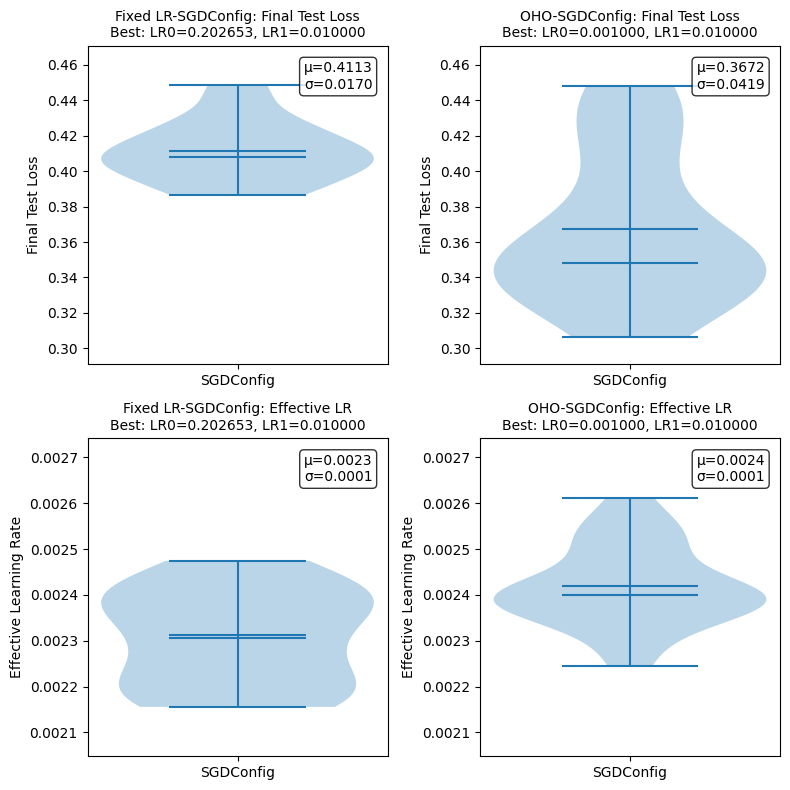

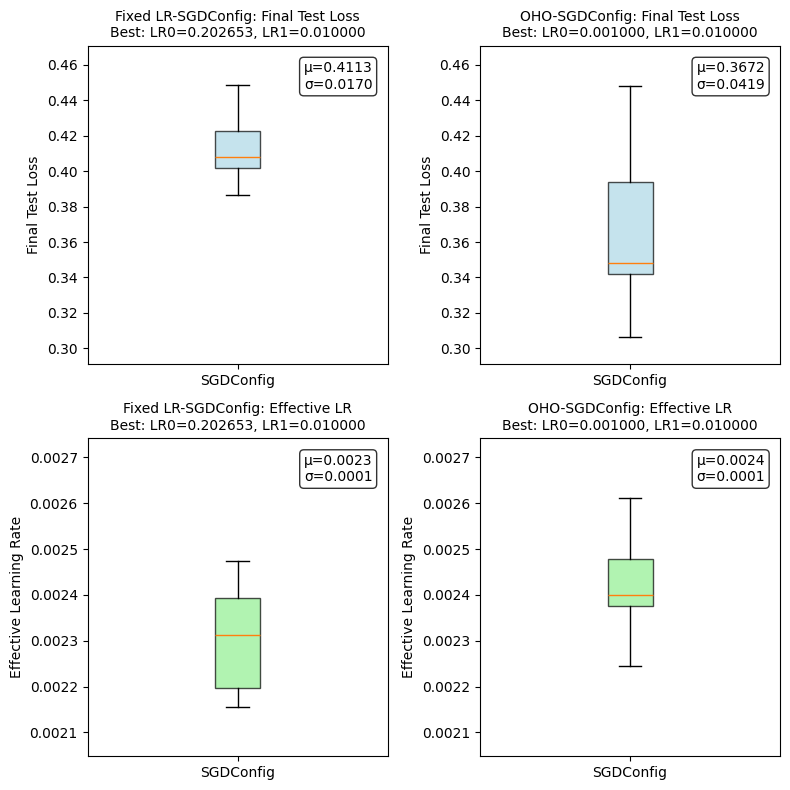


Computing valid test loss curves for Fixed LR-SGDConfig (LR0=0.202653, LR1=0.010000):
    Processing optimizer types: ['SGDConfig']

Computing valid test loss curves for OHO-SGDConfig (LR0=0.001000, LR1=0.010000):
    Processing optimizer types: ['SGDConfig']


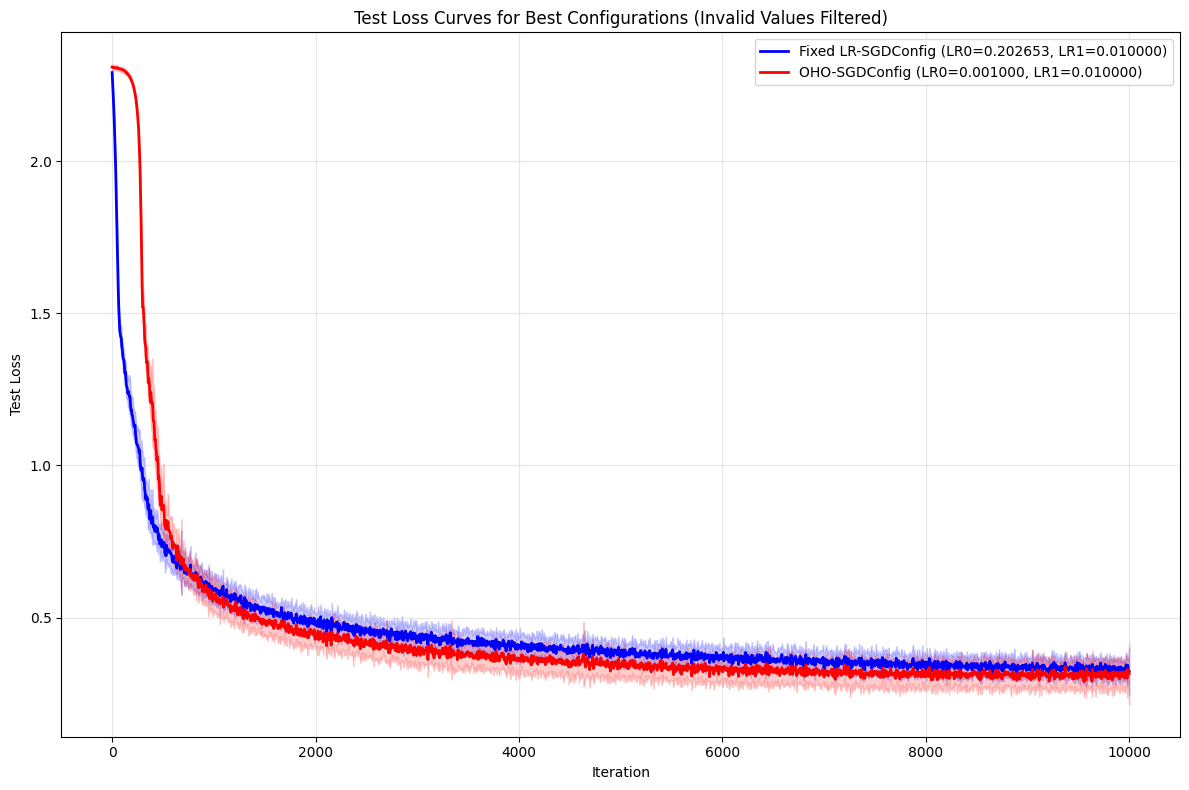


Computing individual test loss curves for Fixed LR-SGDConfig (LR0=0.202653, LR1=0.010000):
    Processing optimizer types: ['SGDConfig']

Computing individual test loss curves for OHO-SGDConfig (LR0=0.001000, LR1=0.010000):
    Processing optimizer types: ['SGDConfig']


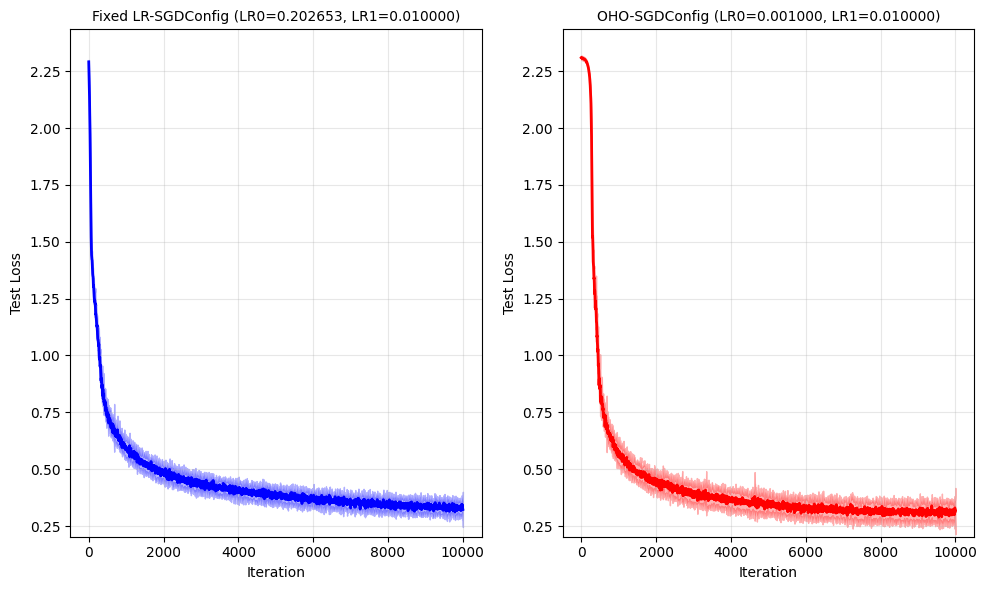

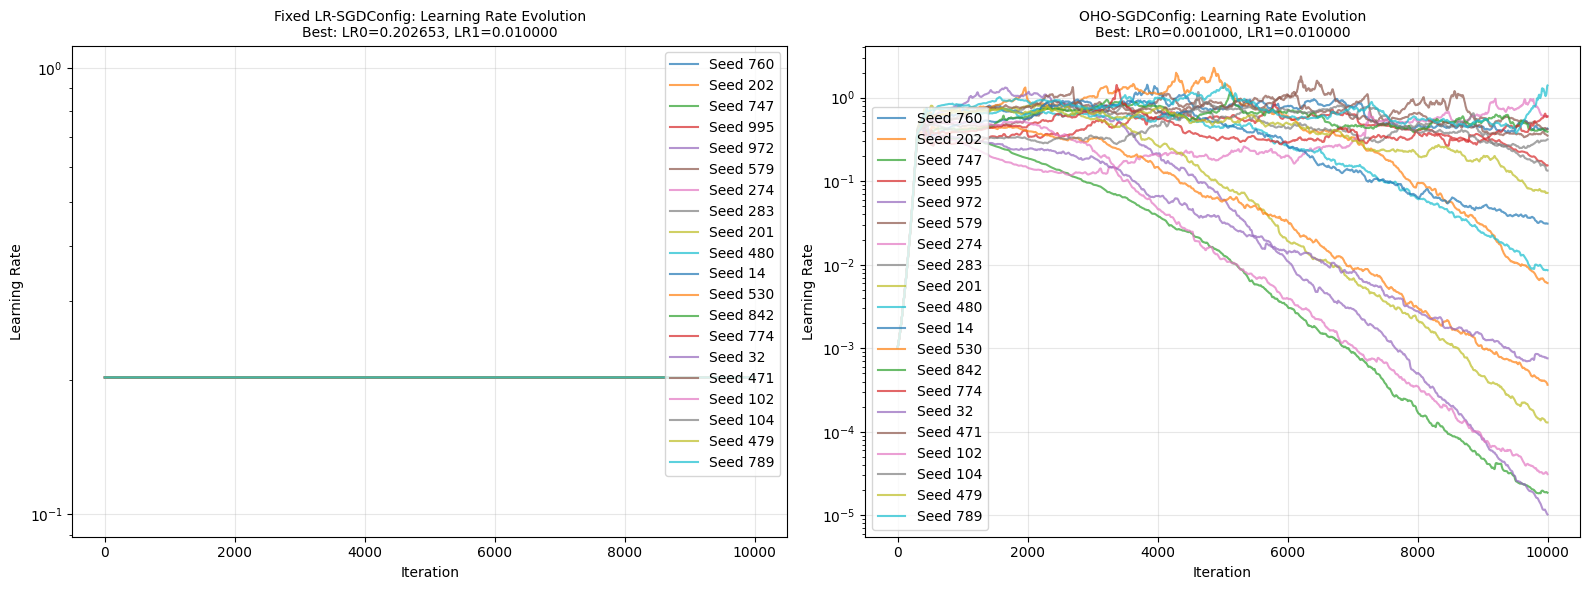


MANN-WHITNEY U TESTS:


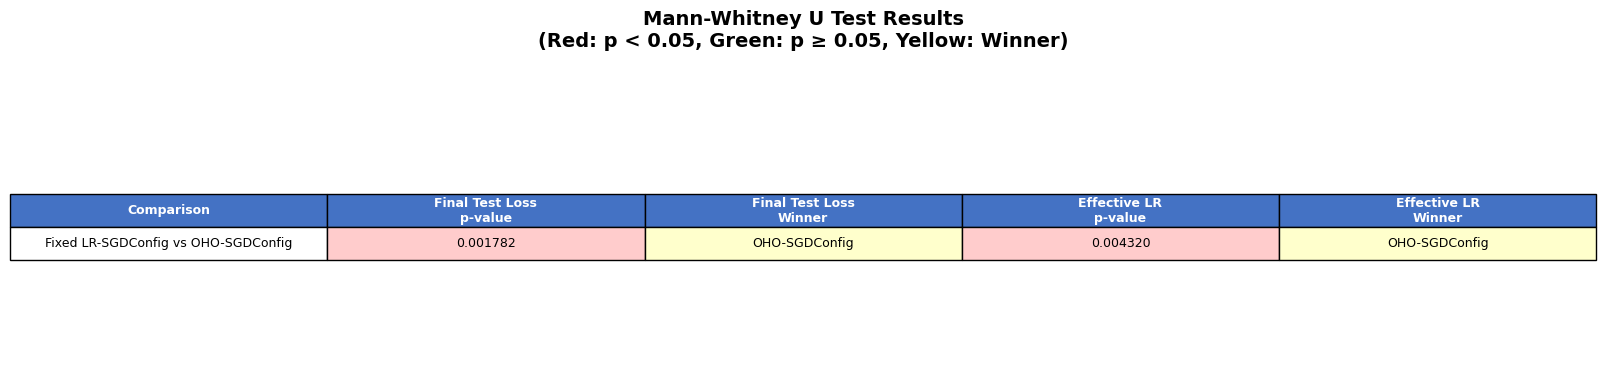


Mann-Whitney U Test Results table displayed above
Note: p < 0.05 indicates significant difference
Final Test Loss: Lower is better
Effective LR: Higher is better (faster convergence)

Fixed LR-SGDConfig vs OHO-SGDConfig:
  Final Test Loss: p=0.001782 - SIGNIFICANT: OHO-SGDConfig has lower final test loss (BETTER)
  Effective LR: p=0.004320 - SIGNIFICANT: OHO-SGDConfig has higher effective LR (BETTER)

CREATING SCATTERPLOT:
Both experiments have similar structure. Assuming Fixed LR is Fixed LR and OHO is OHO
Using Fixed LR (SGDConfig) as Fixed LR baseline with LR=0.202653
Comparing against OHO with optimizer types: ['SGDConfig']

Creating scatterplot for SGDConfig


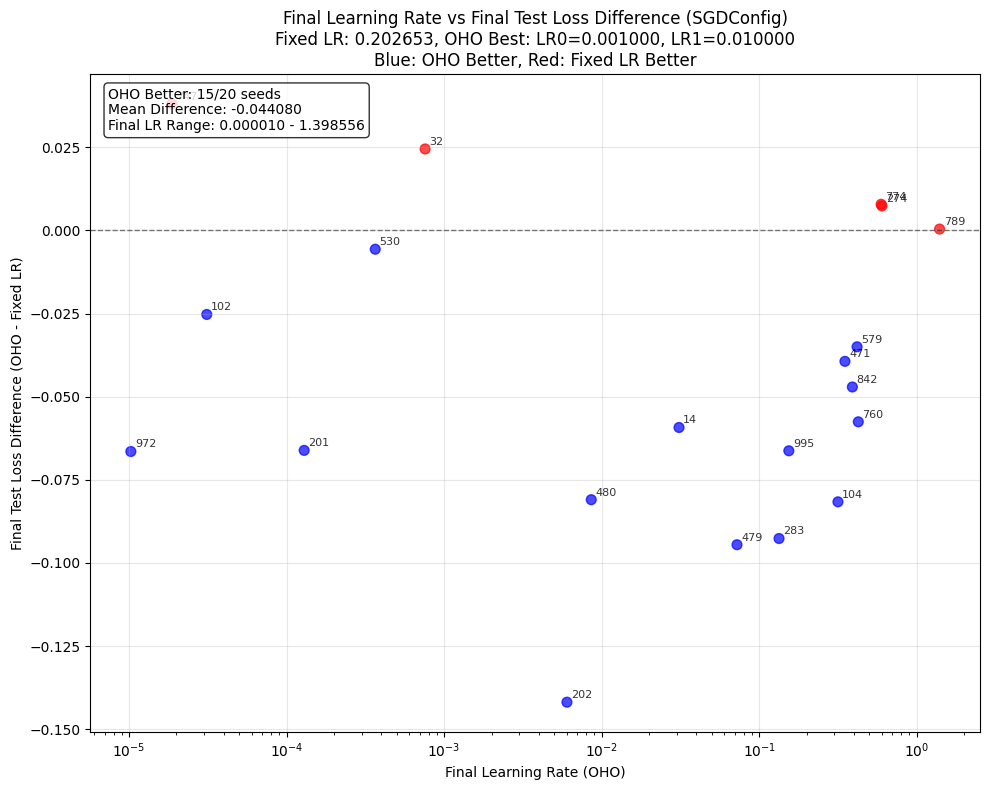


SCATTERPLOT ANALYSIS for SGDConfig:
Total seeds: 20
OHO better (negative diff): 15 seeds
Fixed LR better (positive diff): 5 seeds
Mean loss difference (OHO - Fixed): -0.044080
Std loss difference: 0.045789
Final LR range: 0.000010 to 1.398556
Correlation between final LR and loss difference: 0.3201


In [9]:
# Setup experiment configurations
experiment_configs = [
    (df_exp1, "Fixed LR"),
    (df_exp2, "OHO"),
    # (df_exp3, "OHO extra MLR"), 
    # Add more as needed: (df_exp3, "EXPERIMENT 3"),
]

# Run analysis
results, dataframes = run_analysis(experiment_configs, filter_invalid=True)  # Set to True for original behavior

# Plot and test
plot_and_test(results, dataframes)